In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.io import fits, ascii
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import add_beam, add_scalebar
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.nddata.utils import Cutout2D
from astropy.visualization import simple_norm

from matplotlib.ticker import MultipleLocator
import matplotlib.patheffects as PathEffects

import numpy as np
from numpy.polynomial.polynomial import polyval
from scipy import stats

from molecular_columns import col_h13cop, col_dcop
import velocity_tools.coordinate_offsets as c_offset

plt.rcParams.update({"text.usetex": True,
                     "font.family": "serif",
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'xtick.minor.size': 3,
                     'xtick.major.size': 6,
                     'ytick.minor.size': 3,
                     'ytick.major.size': 6,})

In [2]:
save_figures = False

In [3]:

def Ncol_C18O(TdV, Tex=10*u.K):
    """
    Column density calculation using expression from 
    E. Curtis et al. (2010) doi:10.1111/j.1365-2966.2009.15658.x
    It takes the integrated intensity and returns the C18O column density
    in units of cm^-2
    """
    if TdV.unit != (u.K * u.km / u.s):
        print('Unit of integrated intensity is not K km/s, please modify accordingly')
        return np.nan
    return 5e12 * (Tex/u.K) * np.exp(31.6*u.K/Tex) * (TdV/(u.K*u.km/u.s)) * u.cm**-2

file_yso = 'catalogue/NGC1333_protostar_list.txt'

file_N_H2 = 'data/NGC1333_SE_H2.fits'
file_TdV_DCOp = 'data/NGC1333_DCOp_matched_TdV.fits'
file_TdV_H13COp = 'data/NGC1333_H13COp_matched_TdV.fits'
file_TdV_C18O = 'data/NGC1333_C18O_matched_TdV.fits'

file_tau_C18O = 'data/NGC1333_C18O_tau_v1.fits'

file_Ncol_DCOp_HCOp = 'data/NGC1333_DCOp_HCOp_ratio_coldens.fits'

file_SNR_DCOp = 'data/NGC1333_DCOp_SNR.fits'
file_SNR_HCOp = 'data/NGC1333_H13COp_SNR.fits'

file_fd = 'data/NGC1333_SE_fd.fits'
file_n_H2 = 'data/NGC1333_SE_n_H2.fits'
file_xe_fd = 'data/NGC1333_xe_fd.fits'
file_zeta = 'data/NGC1333_zeta.fits'
file_R_H = 'data/NGC1333_R_H.fits'
file_R_D = 'data/NGC1333_R_D.fits'

file_n_H2_zeta_L1544 = 'data/L1544_model_lowCRIR_1e6yr.dat'

#
X_12CO = 2.7e-4   # see Punanova et al. (2022)
#
R_12CO_C18O = 560 # Wilson & Rood (1994)
R_12C_13C = 68.0 # Milam et al. (2005)

# center and size for cutouts
ra0 = 52.2923239
dec0 = 31.2304113
width = 0.1010000
height = 0.1150000

# Contour levels for N(H_2) in to overplot in figures
levels_H2 = np.arange(22.2, 23.7, 0.5)

# Position of colorbar
col_pos = [0.575, 0.15, 0.35, 0.025]

xpos_lab1, ypos_lab1 = (0.0225, 0.9)
xpos_lab2, ypos_lab2 = (0.0225, 0.85)
xpos_lab3, ypos_lab3 = (0.0225, 0.80)

my_figsize = (5, 5)

cutout_size = u.Quantity((height, width), u.deg)
position = SkyCoord(ra0 * u.deg, dec0 * u.deg, frame='fk5')
# bottom-right corner of NOEMA map 
# this is used to show the data compared to Spitzer image
dx_index = np.array([-1, -1, 1, 1, -1]) * width * 0.5
dy_index = np.array([-1, 1, 1, -1, -1]) * height * 0.5
position_corner_NOEMA = position.spherical_offsets_by(dx_index * u.deg, dy_index * u.deg)  

################################################
# Column density calculations
################################################
N_H2 = fits.getdata(file_N_H2) * u.cm**-2
hdu_log10_h2 = fits.PrimaryHDU(np.log10(fits.getdata(file_N_H2)), 
                               fits.getheader(file_N_H2))

C18O_TdV, hd_C18O = fits.getdata(file_TdV_C18O, header=True)
N_C18O_12K = Ncol_C18O(C18O_TdV*u.K*u.km/u.s, Tex=12*u.K) 
# 

N_CO = N_C18O_12K * R_12CO_C18O
HCOp_TdV, hd_TdV = fits.getdata(file_TdV_H13COp, header=True)
DCOp_TdV, hd_TdV_DCOp = fits.getdata(file_TdV_DCOp, header=True) 

# H12CO+ / H13CO+ = 70
T_ex_DCOp = 10.0 * u.K
T_ex_H13COp = 10.0 * u.K
H13COp_Ncol = col_h13cop.H13COp_thin(J_up=1, Tex=T_ex_H13COp, TdV=HCOp_TdV*u.K*u.km/u.s)
HCOp_Ncol = H13COp_Ncol * R_12C_13C
DCOp_Ncol = col_dcop.DCOp_thin(J_up=1, Tex=T_ex_DCOp, TdV=DCOp_TdV*u.K*u.km/u.s)

SNR_DCOp = fits.getdata(file_SNR_DCOp)
SNR_HCOp = fits.getdata(file_SNR_HCOp)

bad_SNR_DCOp = (SNR_DCOp < 7.5)
bad_SNR_HCOp = (SNR_HCOp < 7.5)
bad_SNR_DCOp_HCOp = (SNR_HCOp < 7.5) | (SNR_DCOp < 7.5)

R_H = HCOp_Ncol.to(u.cm**-2) / N_CO
R_D = DCOp_Ncol / HCOp_Ncol

R_H[bad_SNR_HCOp] = np.nan
R_D[bad_SNR_DCOp_HCOp] = np.nan

fits.writeto('data/NGC1333_Ncol_C18O.fits', N_C18O_12K.value, hd_TdV_DCOp, overwrite=True)
fits.writeto('data/NGC1333_Ncol_DCOp.fits', DCOp_Ncol.value, hd_TdV_DCOp, overwrite=True)
fits.writeto('data/NGC1333_Ncol_H13COp.fits', HCOp_Ncol.value/R_12C_13C, hd_TdV_DCOp, overwrite=True)

hdu_R_D = fits.PrimaryHDU(R_D, hd_TdV_DCOp)
fits.writeto(file_R_D, R_D.value, hd_TdV_DCOp, overwrite=True)
hdu_R_H = fits.PrimaryHDU(R_H, hd_TdV)
fits.writeto(file_R_H, R_H.value, hd_TdV_DCOp, overwrite=True)

n_H2_mean = 1e3

# list of typical values of Zeta from literature
zeta_Caselli98 = 3e-17 #/ u.s
zeta_vanderTak2000 = 3e-17 #/ u.s
zeta_standard = 1e-17 #/ u.s

print('Mean CO Column density = {0:4.2}'.format(np.nanmean(N_CO)))

Mean CO Column density = 9.9e+17 1 / cm2


/var/folders/w3/6j3w0gvj09b442gm4ysq3gmw0000gn/T/ipykernel_27959/419813745.py:72: RuntimeWarning: invalid value encountered in log10
  hdu_log10_h2 = fits.PrimaryHDU(np.log10(fits.getdata(file_N_H2)),


In [4]:
distance = 300. # pc
# Load YSO catalogue
ra_yso, dec_yso = np.loadtxt(file_yso, unpack=True)
marker_size = 50
# load polarisation vector catalogue
data_pol = ascii.read('catalogue/N1333_PA.csv')
ra_pol = np.rad2deg(data_pol['ra'])
dec_pol = np.rad2deg(data_pol['dec'])
dra_pol = np.sin(data_pol['PA'] + np.pi/2) * 2
ddec_pol = np.cos(data_pol['PA'] + np.pi/2) * 2
# load X-Ray sources catalogue
data_xray = ascii.read('catalogue/table3_Xray_YSO.dat', format='fixed_width', delimiter=' ')
ra_xray = 15 * (data_xray['H'] + (data_xray['MM'] + data_xray['SS.SS'] / 60.) /60.)
dec_xray =  data_xray['dg'] + (data_xray['mm'] + data_xray['ss.ss'] / 60.) /60.

def load_cutout(file_in, is_hdu=False):
    """
    Convenience function to load a FITS file, or an existing HDU, 
    and to generate a cutout following the requested center and sizes.
    
    params:
    
    file_in : FITS file name to be loaded (if is_hdu=False). If is_hdu=True, 
              the file_in represents a valid HDU to be used.
    is_hdu : Boolean parameter. It controls what is passed to the function.
    
    Return:
    It returns the HDU of the cutout defined by the global variables: position and cutout_size.
    """
    if is_hdu==False:
        hdu = fits.open(file_in)[0]
    else:
        hdu = file_in.copy()
    # Make the cutout, including the WCS
    cutout = Cutout2D(hdu.data, position=position, size=cutout_size, wcs=WCS(hdu.header))
    hdu.data = cutout.data
    hdu.header.update(cutout.wcs.to_header())
    return hdu

def plot_setup_noema_wcsaxes(ax, hdu, label_col='black', contour_h2=False):
    # get axes coordinates
    ra_ax = ax.coords[0] # lon
    dec_ax = ax.coords[1] # lat
    # Sets formatting
    ra_ax.set_major_formatter('hh:mm:ss')
    dec_ax.set_major_formatter('dd:mm')
    ra_ax.display_minor_ticks(True)
    dec_ax.display_minor_ticks(True)
    # set ticks spacing and minor tick paramters
    ra_ax.set_ticks(spacing=8 * 15 * u.arcsec, color=label_col)
    dec_ax.set_ticks(spacing=2 * u.arcmin, color=label_col)
    ra_ax.set_minor_frequency(4)
    dec_ax.set_minor_frequency(4)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=3)
    ax.tick_params(color=label_col)
    # Add YSO lists
    ax.autoscale(enable=False)
    ax.scatter(ra_yso, dec_yso, marker='*', s=marker_size, c='white', edgecolor='black',
                 linewidth=1.5, zorder=24, alpha=0.5, transform=ax.get_transform('world'))
    # H2 column density contours
    if contour_h2:
        ax.contour(hdu_log10_h2.data, levels=levels_H2, 
                   transform=ax.get_transform(WCS(hdu_log10_h2.header)), 
                   colors=label_col, linewidths=1, alpha=0.5)
    # Add beamsize
    # for smaller beams the padding needs to be larger
    #
    if hdu.header['BMAJ'] > 10*u.arcsec.to(u.deg):
        add_beam(ax, header=hdu.header, frame=False, pad=0.2, 
                 color=label_col, corner='top left')
    else:
        add_beam(ax, header=hdu.header, frame=False, pad=0.5, 
                 color=label_col, corner='top left')
    # Scalebar
    length = (5e3*u.au / (distance*u.pc)).to(u.deg, u.dimensionless_angles())
    add_scalebar(ax, length, label="5,000 au", color=label_col, corner='bottom right')
    #
    ax.set_xlabel(r'Right Ascension (J2000)')
    ax.set_ylabel(r'Declination (J2000)')


## Spitzer image of NGC 1333
The NGC 1333 region was mapped by the c2d project with Spitzer. It is a nice figure to show the area mapped with NOEMA and 30-m.

In [5]:
image_r, hd_NGC1333 = fits.getdata('data/NGC1333_IRAC4.fits', header=True)
image_g = fits.getdata('data/NGC1333_IRAC2.fits')
image_b = fits.getdata('data/NGC1333_IRAC1.fits')
#
log_min_r = 6.5; log_max_r = 120.0
log_min_g = 0.18; log_max_g = 45.0
log_min_b = 0.14; log_max_b = 42.0
# R
log_image_r = np.clip(np.log10(image_r - log_min_r) / np.log10(log_max_r - log_min_r), 0, 1) * 255
log_image_r[np.isnan(log_image_r)] = 0
# G
log_image_g = np.clip(np.log10(image_g / log_min_g) / np.log10(log_max_g / log_min_g), 0, 1) * 255
log_image_g[np.isnan(log_image_g)] = 0
# B
log_image_b = np.clip(np.log10(image_b / log_min_b) / np.log10(log_max_b / log_min_b), 0, 1) * 255
log_image_b[np.isnan(log_image_b)] = 0
# RGB Assemble
image_rgb_log = np.dstack([log_image_r, log_image_g, log_image_b]).astype(np.uint8)

/var/folders/w3/6j3w0gvj09b442gm4ysq3gmw0000gn/T/ipykernel_27959/174745202.py:12: RuntimeWarning: invalid value encountered in log10
  log_image_g = np.clip(np.log10(image_g / log_min_g) / np.log10(log_max_g / log_min_g), 0, 1) * 255
/var/folders/w3/6j3w0gvj09b442gm4ysq3gmw0000gn/T/ipykernel_27959/174745202.py:15: RuntimeWarning: invalid value encountered in log10
  log_image_b = np.clip(np.log10(image_b / log_min_b) / np.log10(log_max_b / log_min_b), 0, 1) * 255


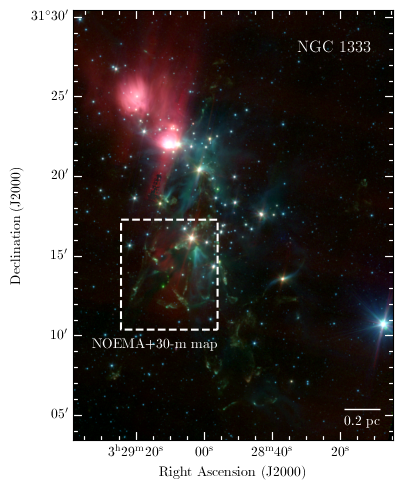

In [6]:
text_color = 'white'

wcs = WCS(hd_NGC1333)

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(image_rgb_log, origin='lower')

ra_ax = ax.coords[0] # lon
dec_ax = ax.coords[1] # lat
# Sets formatting
ra_ax.set_major_formatter('hh:mm:ss')
dec_ax.set_major_formatter('dd:mm')
ra_ax.display_minor_ticks(True)
dec_ax.display_minor_ticks(True)
# set ticks spacing and minor tick paramters
ra_ax.set_ticks(spacing=15 * 20 * u.arcsec, color=text_color)
dec_ax.set_ticks(spacing=5 * u.arcmin, color=text_color)
ra_ax.set_minor_frequency(4)
dec_ax.set_minor_frequency(5)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3)
ax.tick_params(color=text_color)
ax.autoscale(enable=False)
#
fig.text(0.7, ypos_lab1, 'NGC 1333', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
# Scalebar
length = (0.2*u.pc / (distance*u.pc)).to(u.deg, u.dimensionless_angles())
add_scalebar(ax, length, label="0.2 pc", color=text_color, corner='bottom right')
#
ax.set_xlabel(r'Right Ascension (J2000)')
ax.set_ylabel(r'Declination (J2000)')
#
ax.plot(position_corner_NOEMA.ra, position_corner_NOEMA.dec, color='white', 
        transform=ax.get_transform('fk5'), linestyle="--")
ax.text(position_corner_NOEMA.ra[0].deg, (position_corner_NOEMA.dec[0] - 0.02*u.deg).deg,
    "NOEMA+30-m map", color=text_color, transform=ax.get_transform('fk5'), ha='right')

plt.tight_layout()
if save_figures:
    fig.savefig('figs/NGC1333_Overall.pdf', bbox_inches='tight', dpi=1200)

## Data used
### Herschel maps
We use the column density map from Herschel as a good estimate of the total H$_2$ column density.

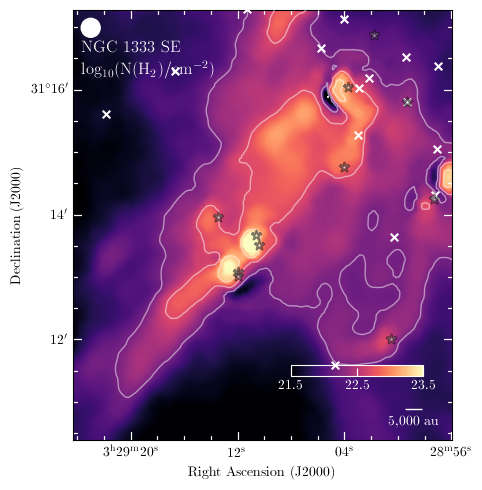

In [7]:
text_color = 'white'

# copy HDU with log_10(N(H_2))
hdu = load_cutout(hdu_log10_h2, is_hdu=True)
# hdu = hdu_log10_h2.copy()
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='magma').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, cmap=cmap, vmin=21.5, vmax=23.5, origin='lower')
# im = ax.imshow(np.log10(hdu.data), cmap=cmap, vmin=21.5, vmax=23.5, origin='lower') #vmin=0.2, vmax=1.0, 

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_h2=True)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'', orientation='horizontal')
#
cbar.set_ticks([21.5, 22.5, 23.5])#
cbar.ax.xaxis.set_ticklabels([21.5, 22.5, 23.5], color=text_color)
# set colorbar tick color
cbar.ax.xaxis.set_tick_params(color=text_color)
# set colorbar edgecolor 
cbar.outline.set_edgecolor(text_color)
#
fig.text(xpos_lab1, ypos_lab1, 'NGC 1333 SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'log$_{10}$(N(H$_2$)/cm$^{-2}$)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)

plt.tight_layout()
if save_figures:
    fig.savefig('figs/NGC1333_H2.pdf', dpi=200, bbox_inches='tight')

# Add X-Ray sources
ax.scatter(ra_xray, dec_xray, marker='x', s=30, zorder=20,
           transform=ax.get_transform('world'), color='w')
if save_figures:
    fig.savefig('figs/NGC1333_H2_with_Xray.pdf', dpi=200, bbox_inches='tight')

### JCMT
The map of the HARPS JCMT C$^{18}$O (3--2) emission is shown. This will be used to estimate the total CO column density.

Set OBSGEO-B to    19.825833 from OBSGEO-[XYZ].
Set OBSGEO-H to       -3.003 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    19.825833 from OBSGEO-[XYZ].
Set OBSGEO-H to       -3.003 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


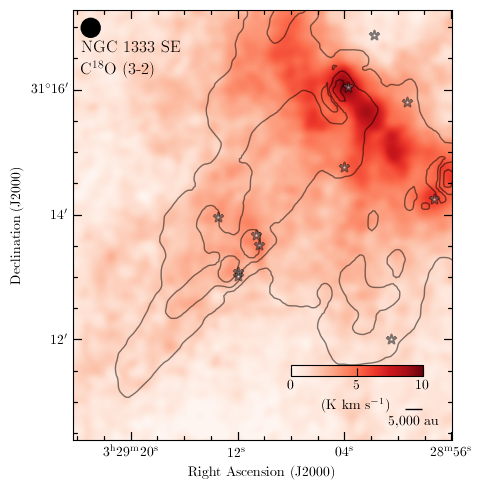

In [8]:
text_color = 'black'

hdu = load_cutout(file_TdV_C18O)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Reds').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, cmap=cmap, vmin=0.0, vmax=10, origin='lower') #vmin=0.2, vmax=1.0, 

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_h2=True)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(K km s$^{-1}$)', orientation='horizontal')
cbar.set_ticks([0, 5, 10])

fig.text(xpos_lab1, ypos_lab1, 'NGC 1333 SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'C$^{18}$O (3-2)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)

plt.tight_layout()
if save_figures:
    fig.savefig('figs/NGC1333_C18O_TdV.pdf', dpi=200, bbox_inches='tight')

### NOEMA data
#### Integrated intensity maps
We show the integrated intensity maps for both transitions used, DCO$^+$ (1--0) and H$^{13}$CO$^+$ (1--0).

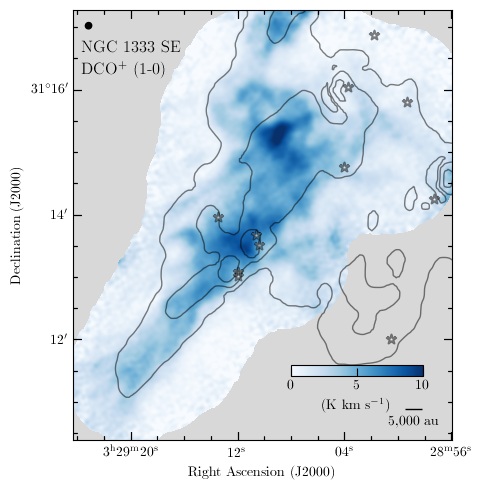

In [9]:
text_color = 'black'

hdu = load_cutout(file_TdV_DCOp)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Blues').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, cmap=cmap, vmin=0.0, vmax=10, origin='lower') #vmin=0.2, vmax=1.0, 

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_h2=True)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(K km s$^{-1}$)', orientation='horizontal')
cbar.set_ticks([0, 5, 10])

fig.text(xpos_lab1, ypos_lab1, 'NGC 1333 SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'DCO$^+$ (1-0)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)

plt.tight_layout()
if save_figures:
    fig.savefig('figs/NGC1333_DCOp_TdV.pdf', dpi=200, bbox_inches='tight')

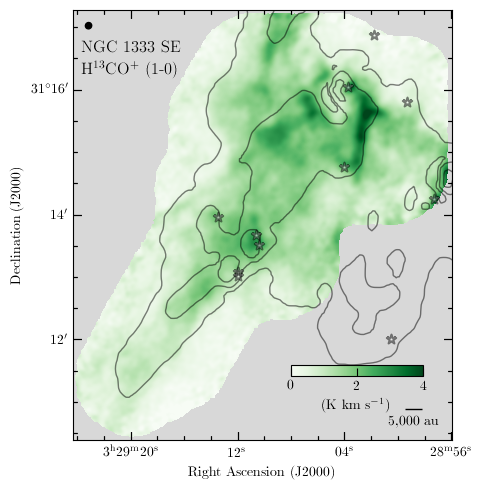

In [10]:
text_color = 'black'

hdu = load_cutout(file_TdV_H13COp)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Greens').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, cmap=cmap, vmin=0.0, vmax=4.0, origin='lower') #vmin=0.2, vmax=1.0, 

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_h2=True)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(K km s$^{-1}$)', orientation='horizontal')
cbar.set_ticks([0, 2, 4])

fig.text(xpos_lab1, ypos_lab1, 'NGC 1333 SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'H$^{13}$CO$^+$ (1-0)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)

plt.tight_layout()
if save_figures:
    fig.savefig('figs/NGC1333_H13COp_TdV.pdf', dpi=200, bbox_inches='tight')

### DCO$^+$ and HCO$^+$ ratio
We use the derived column densities to estimate the value of the ratio, $R_D$.

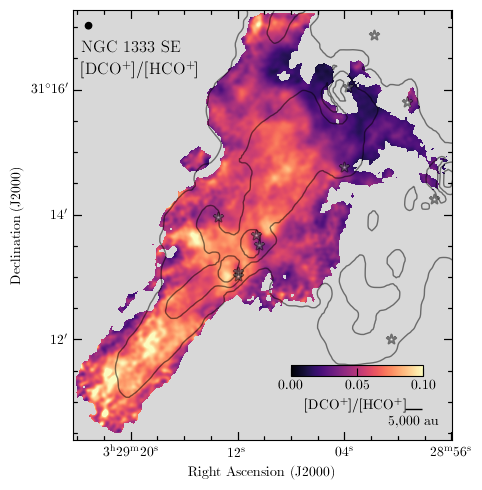

In [11]:
text_color = 'black'

hdu = load_cutout(hdu_R_D, is_hdu=True)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='magma').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, cmap=cmap, vmin=0.0, vmax=0.1, origin='lower')

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_h2=True)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'[DCO$^{+}$]/[HCO$^{+}$]', orientation='horizontal')
cbar.set_ticks([0, 0.05, 0.1])

fig.text(xpos_lab1, ypos_lab1, 'NGC 1333 SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'[DCO$^{+}$]/[HCO$^{+}$]', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)

plt.tight_layout()
if save_figures:
    fig.savefig('figs/NGC1333_Ncol_DCOp_HCOp.pdf', dpi=200, bbox_inches='tight')

## CO Depletion
### H$_2$ and C$^{18}$O comparison: 

The H$_2$ column density is likely tracing material which is not seen by C$^{18}$O. If this is a single offset, it can be estimated as:
$$
\delta(N_{\rm H_2}) = N(H_2) - N(C^{18}O)/X_{0,18}~,
$$
where $X_{0,18}$ is the abundance ($2.7\times 10^{-4} / 560 $).

The $\delta(N_{\rm H_2})$ is estimated over the range on which $N(H_2)<5\times 10^{21} {\rm cm^{-2}}$.

In [12]:
gd = (N_CO > 0.0)*(N_H2 > 10**(21.5)/u.cm**2)
gd_delta = (N_CO > 0.0) * (N_H2 > 10**(21.5)/u.cm**2) * (N_H2 < 5e21/u.cm**2)
N_CO_H2 = N_CO/X_12CO
delta_H2 = N_H2 - N_CO_H2
mean_delta_H2 = np.mean(delta_H2[gd_delta])
print(np.round(mean_delta_H2*1e-21, decimals=1)*1e21)

f_D = (N_H2 - mean_delta_H2) / N_CO_H2
f_D[~gd] = np.nan

x_line = np.array([0, 200])/u.cm**2

# hd_fd = hd_TdV.copy()
hd_fd = hdu_log10_h2.header.copy()
hd_fd['BUNIT'] = ''
hdu_fd = fits.PrimaryHDU(f_D, hd_fd)
fits.writeto(file_fd, f_D.value, hd_fd, overwrite=True)

print(np.nanmax(f_D))

2.7e+21 1 / cm2
425.53231843350426


Let's plot the derived offset as a function of H$_2$ column density, to identify how reliable is this estimate. This is not included in the paper.

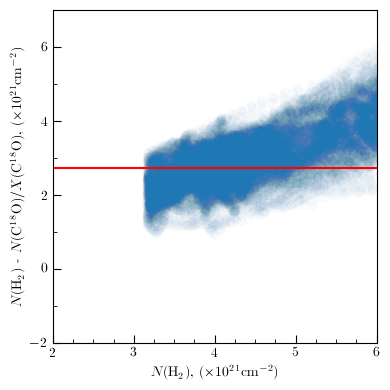

In [13]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(N_H2[gd]*1e-21, delta_H2[gd]*1e-21, alpha=0.01)

ax.plot(x_line, x_line*0.0 + mean_delta_H2*1e-21, color='r')

ax.set_xlabel(r"$N({\rm H_2})$, ($\times 10^{21} {\rm cm^{-2}}$)")
ax.set_ylabel(r"$N({\rm H_2})$ - $N({\rm C^{18}O})/X({\rm C^{18}O})$, ($\times 10^{21} {\rm cm^{-2}}$)")
#

ax.xaxis.set_minor_locator(MultipleLocator(0.25))
ax.yaxis.set_minor_locator(MultipleLocator(1))

ax.set_yticks([-2, 0, 2, 4, 6])
ax.set_xlim(2, 6)
ax.set_ylim(-2, 7)

plt.tight_layout()
if save_figures:
    fig.savefig('figs/NGC1333_delta_H2_C18O_scatter_zoom.pdf', dpi=100, bbox_inches='tight')

Now we display the depletion fraction map for the region.

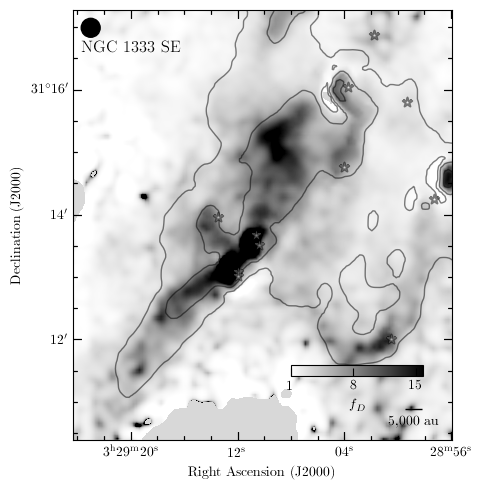

In [14]:
text_color = 'black'

hdu = load_cutout(hdu_fd, is_hdu=True)
# hdu = load_cutout(fits.PrimaryHDU((f_d), hd_d_JCMT), is_hdu=True)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='gray_r').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin=1.0, vmax=20, cmap=cmap, origin='lower')

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_h2=True)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
cbar.set_label(r'$f_D$', color=text_color)
cbar.set_ticks([1, 10, 19])
cbar.ax.xaxis.set_ticklabels([1, 8, 15], color=text_color)
# set colorbar tick color
cbar.ax.xaxis.set_tick_params(color=text_color)
# set colorbar edgecolor 
cbar.outline.set_edgecolor(text_color)

fig.text(xpos_lab1, ypos_lab1, 'NGC 1333 SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)

plt.tight_layout()
if save_figures:
    fig.savefig('figs/NGC1333_fd.pdf', dpi=200, bbox_inches='tight')

Set OBSGEO-B to    19.825833 from OBSGEO-[XYZ].
Set OBSGEO-H to       -3.003 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    19.825833 from OBSGEO-[XYZ].
Set OBSGEO-H to       -3.003 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


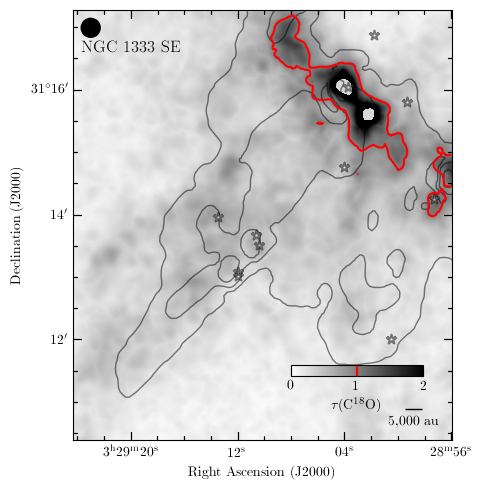

In [15]:
text_color = 'black'

hdu = load_cutout(file_tau_C18O, is_hdu=False)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='gray_r').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin=0.0, vmax=2, cmap=cmap, origin='lower')

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_h2=True)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
cbar.set_label(r'$\tau({\rm C^{18}O})$', color=text_color)
cbar.set_ticks([0, 1, 2])
# set colorbar tick color
cbar.ax.xaxis.set_tick_params(color=text_color)
# set colorbar edgecolor 
cbar.outline.set_edgecolor(text_color)

im_count = ax.contour(hdu.data, levels=[1.0], colors='red')
cbar.ax.axvline(1, c='red')

fig.text(xpos_lab1, ypos_lab1, 'NGC 1333 SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)

plt.tight_layout()
if save_figures:
    fig.savefig('figs/NGC1333_tau_C18O.pdf', dpi=200, bbox_inches='tight')

### H$_2$ density
We estimate the density as 
\begin{equation}
 n({\rm H}_2) =  \frac{N({\rm H_2}) - \delta(N_{\rm H_2})}{depth}~,
\end{equation}
and assuming a depth of 0.4 pc.

In [16]:
n_H2 = ( (N_H2 - delta_H2) / (0.4*u.pc)).to(1./u.cm**3)
n_H2[n_H2 < 0.0] = np.nan

mean_log_n_H2 = np.mean(np.log10(n_H2[np.isfinite(hdu_R_D.data)].value))
print("The mean of the log(density/cc) = {0:3.1f}".format(mean_log_n_H2))

hd_n_H2 = hdu_log10_h2.header.copy()
hd_n_H2['BUNIT'] = 'cm**-3'
hdu_n_H2 = fits.PrimaryHDU(n_H2, hd_n_H2)
fits.writeto(file_n_H2, n_H2.value, hd_n_H2, overwrite=True)

The mean of the log(density/cc) = 3.6


This provides a map of the mean volume density, estimated from the Herschel column density maps.

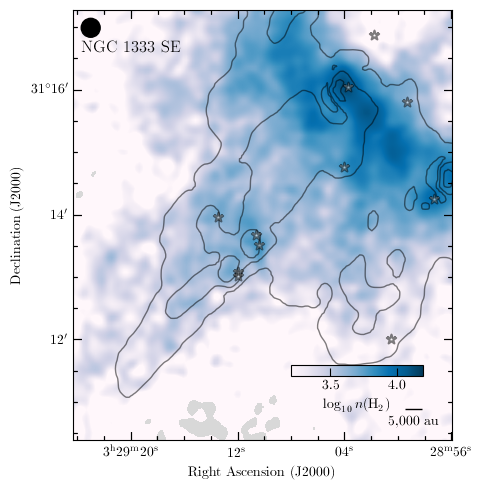

In [17]:
text_color = 'black'

hdu = load_cutout(hdu_n_H2, is_hdu=True)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='PuBu').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(np.log10(hdu.data.value), vmin=3.2, vmax=4.2, cmap=cmap, origin='lower')

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_h2=True)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
cbar.set_label(r'$\log_{10}n({\rm H_2})$', color=text_color)
# set colorbar tick color
cbar.ax.xaxis.set_tick_params(color=text_color)
# set colorbar edgecolor 
cbar.outline.set_edgecolor(text_color)

fig.text(xpos_lab1, ypos_lab1, 'NGC 1333 SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)

plt.tight_layout()
if save_figures:
    fig.savefig('figs/NGC1333_n_H2.pdf', dpi=200, bbox_inches='tight')

## Electron Fraction map

For this we use the previous expresion, and the derived values of $R_d$ and $f_D$.

In [18]:
## Relation from Caselli+1998
xe_fd = 2.7e-8 / R_D - 1.2e-6 / f_D
xe_fd[xe_fd < 0] = np.nan
log10_xe_fd = np.log10(xe_fd).value

fits.writeto(file_xe_fd, log10_xe_fd, hd_TdV, overwrite=True)
fits.setval(file_xe_fd, 'BUNIT', value='')

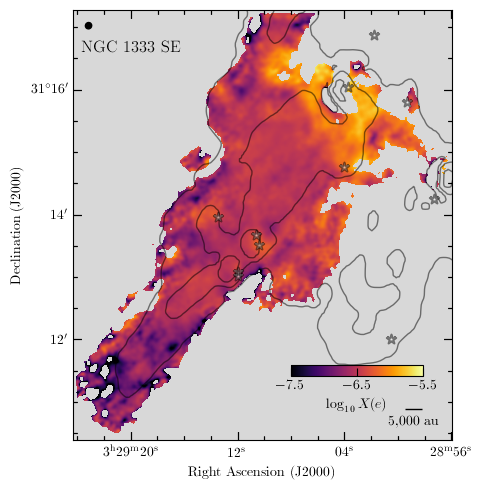

In [19]:
text_color = 'black'

hdu = load_cutout(fits.PrimaryHDU(log10_xe_fd, hd_TdV), is_hdu=True)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='inferno').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin=-7.5, vmax=-5.5, cmap=cmap, origin='lower')

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_h2=True)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'$\log_{10} X(e)$', orientation='horizontal')
cbar.set_ticks([-7.5, -6.5, -5.5])

fig.text(xpos_lab1, ypos_lab1, 'NGC 1333 SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)

plt.tight_layout()
if save_figures:
    fig.savefig('figs/NGC1333_xe_fd.pdf', dpi=200, bbox_inches='tight')

In [20]:
sigma_levels = np.array([0.5, 1.0, 1.5, 2.0])
sigma_levels_l = np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0])
filled_levels = np.hstack([0, sigma_levels])  # 9000 sigmas ~ np.inf
filled_levels_l = np.hstack([0, sigma_levels_l])  # 9000 sigmas ~ np.inf
levels_norm = np.exp(-0.5 * sigma_levels ** 2)[::-1]
levels_norm_f = np.exp(-0.5 * filled_levels ** 2)[::-1]
levels_norm_l = np.exp(-0.5 * filled_levels_l ** 2)[::-1]

color_kde = ['#e41a1c', '#377eb8', '#a65628']
color_levels = ['#ffffcc', '#ffeda0', '#fed976', '#feb24c',
                '#fd8d3c', '#fc4e2a', '#e31a1c', '#b10026']
color_levels2 = ['#deebf7', '#c6dbef', '#9ecae1', '#6baed6',
                 '#4292c6', '#2171b5', '#08519c', '#08306b']

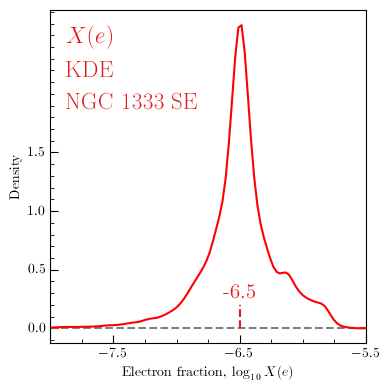

In [21]:
log_xe = np.log10(xe_fd)

xrange = np.array([-8.0, -5.5])

gd_xe = np.isfinite(log_xe)
# wt = 1 / NH3_dv[log_xe]**2
#
kde_log_xe = stats.gaussian_kde(log_xe[gd_xe])#, weights=wt)
median_log10_xe = np.round(np.median(log_xe[gd_xe].value), decimals=1)

x_sample = np.linspace(xrange[0], xrange[1], num=100)
log_xe_sample = np.reshape(kde_log_xe(x_sample).T, x_sample.shape)

fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(xrange, [0, 0], color='gray', linestyle='--')
ax.plot(x_sample, log_xe_sample, color='red', label=r'$\sigma_v$')
#
ax.text(0.05, 0.9,  r'$X(e)$', color=color_kde[0],
        transform=ax.transAxes, size=17, weight=60)
ax.text(0.05, 0.8,  r'KDE', color=color_kde[0],
        transform=ax.transAxes, size=17, weight=60)
ax.text(0.05, 0.7,  r'NGC 1333 SE', color=color_kde[0],
        transform=ax.transAxes, size=17, weight=60)

ax.set_xlabel(r"Electron fraction, $\log_{10} X(e)$")
ax.set_ylabel(r"Density")
ax.set_xlim(xrange)

# plot median value
ax.plot([median_log10_xe, median_log10_xe], [0, 0.2], 
        color=color_kde[0], linestyle='--')
ax.text(median_log10_xe, 0.25, median_log10_xe, color=color_kde[0], 
        horizontalalignment='center', size=15, weight=60)
    
ax.xaxis.set_minor_locator(MultipleLocator(0.25))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))

ax.set_xticks([-7.5, -6.5, -5.5])
ax.set_yticks([0, 0.5, 1, 1.5])

plt.tight_layout()
if save_figures:
    fig.savefig('figs/NGC1333_log_xe_KDE.pdf', dpi=100, bbox_inches='tight')

### Compare between CO depletion fraction and Electron Fraction

In [22]:
fd_min = 1.0
fd_max = 35
xe_min = -8.0
xe_max = -4.5
gd_map = np.isfinite(f_D * log_xe)
my_X = f_D[gd_map]
my_Y = log_xe[gd_map]

xx_fd_xe, yy_fd_xe = np.mgrid[fd_min:fd_max:100j, xe_min:xe_max:100j]
positions = np.vstack([xx_fd_xe.ravel(), yy_fd_xe.ravel()])
values = np.vstack([my_X, my_Y])
kernel_fd_xe = stats.gaussian_kde(values)
my_Z = np.reshape(kernel_fd_xe(positions).T, xx_fd_xe.shape)

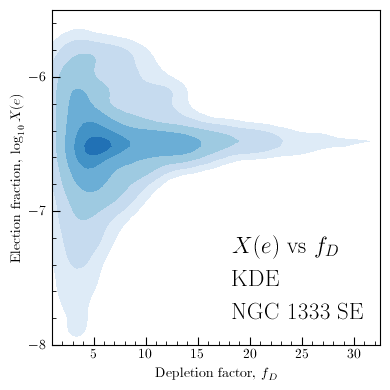

In [23]:
fig, ax = plt.subplots(figsize=(4, 4))

levels = levels_norm * my_Z.max()
cfset = ax.contourf(xx_fd_xe, yy_fd_xe, my_Z, colors=color_levels2, 
                    levels=levels_norm_l * my_Z.max())
#
ax.set_xlim([1, 32.5])
ax.set_ylim([-8, -5.5])
#
ax.set_xlabel(r"Depletion factor, $f_D$")
ax.set_ylabel(r"Election fraction, $\log_{10} X(e)$")
#

ax.text(0.55, 0.075,  r'NGC 1333 SE', color='black', 
        transform=ax.transAxes, size=17, weight=60)
ax.text(0.55, 0.175,  r'KDE', color='black', 
        transform=ax.transAxes, size=17, weight=60)
ax.text(0.55, 0.275,  r'$X(e)$ vs $f_D$', color='black', 
        transform=ax.transAxes, size=17, weight=60)

ax.set_yticks([-8, -7, -6])
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.2))
#
plt.tight_layout()
if save_figures:
    fig.savefig('figs/NGC1333_log_xe_fd_KDE.pdf', dpi=100, bbox_inches='tight')

### Compare between H$_2$ density and Electron Fraction
For this we compare the density and electron fraction relations from McKee (1989) and Caselli et al (2002), and the result from modeling L1544 (Redaelli et al. 2021).

In [24]:
def ion_fraction(dens_all, do_Caselli=True):
    """
    1.3e-5 x n(H2)^{0.5}  (from McKee 1989) or 5.2e-6 x n*H2)^{0.44} 
    """
    if do_Caselli:
        xe = 5.2e-6 * (dens_all/(u.cm**-3))**-0.56
    else:
        xe = 1.3e-5 * (dens_all/(u.cm**-3))**-0.5
    return xe

data_L1544 = ascii.read(file_n_H2_zeta_L1544)

In [25]:
log_n_H2_min = 2.5
log_n_H2_max = 4.5
xe_min = -8.5
xe_max = -4.5
gd_map = np.isfinite(n_H2 * log_xe)
my_X = np.log10(n_H2[gd_map] * u.cm**3)
my_Y = log_xe[gd_map]

xx_n_H2_xe, yy_n_H2_xe = np.mgrid[log_n_H2_min:log_n_H2_max:100j, xe_min:xe_max:100j]
positions = np.vstack([xx_n_H2_xe.ravel(), yy_n_H2_xe.ravel()])
values = np.vstack([my_X, my_Y])
kernel_n_H2_xe = stats.gaussian_kde(values)
my_Z = np.reshape(kernel_n_H2_xe(positions).T, xx_n_H2_xe.shape)

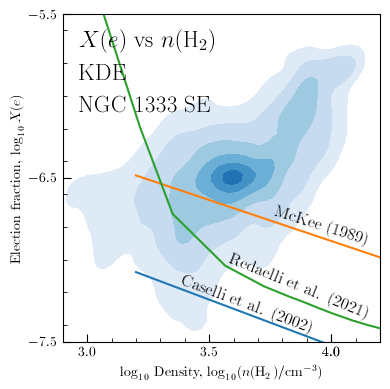

In [26]:
fig, ax = plt.subplots(figsize=(4, 4))

levels = levels_norm * my_Z.max()
cfset = ax.contourf(xx_n_H2_xe, yy_n_H2_xe, my_Z, colors=color_levels2, 
                    levels=levels_norm_l * my_Z.max())
#
ax.set_xlim([2.9, 4.2])
ax.set_ylim([-7.5, -5.5])

n_H2_sample = 10**(np.arange(3.2, 4.5, 0.1))/u.cm**3
#
ax.set_xlabel(r"$\log_{10}$ Density, $\log_{10}(n({\rm H_2) /cm^{-3}})$")
ax.set_ylabel(r"Election fraction, $\log_{10} X(e)$")
#
ax.text(0.05, 0.70,  r'NGC 1333 SE', color='black', 
        transform=ax.transAxes, size=17, weight=60)
ax.text(0.05, 0.80,  r'KDE', color='black', 
        transform=ax.transAxes, size=17, weight=60)
ax.text(0.05, 0.90,  r'$X(e)$ vs $n({\rm H_2})$', color='black', 
        transform=ax.transAxes, size=17, weight=60)
#
# Plot curves from models
#
ax.plot(np.log10(n_H2_sample*u.cm**3), np.log10(ion_fraction(n_H2_sample, do_Caselli=True)), label='Caselli')
ax.plot(np.log10(n_H2_sample*u.cm**3), np.log10(ion_fraction(n_H2_sample, do_Caselli=False)), label='McKee')
ax.plot(np.log10(data_L1544['n(H2)']), np.log10(data_L1544['e-']))
#
# Labels for curves
#
ax.text(0.975, 0.295,  r'McKee (1989)', color='black', rotation=-17.5,
        transform=ax.transAxes, size=12, weight=60, horizontalalignment='right')
ax.text(0.975, 0.07,  r'Redaelli et al. (2021)', color='black', rotation=-22,
        transform=ax.transAxes, size=12, weight=60, horizontalalignment='right')
ax.text(0.80, 0.0250,  r'Caselli et al. (2002)', color='black', rotation=-20.5,
        transform=ax.transAxes, size=12, weight=60, horizontalalignment='right')
#
# Setup for Ticks
#
ax.set_xticks([3.0, 3.5, 4, 4])
ax.set_yticks([-7.5, -6.5, -5.5])
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.2))
#
plt.tight_layout()
if save_figures:
    fig.savefig('figs/NGC1333_log_xe_log_n_H2_KDE.pdf', dpi=100, bbox_inches='tight')

## Cosmic Ray ionization rate
We estimate the Cosmic Ray ionization rate using the following relation (from Caselli et al. 1998),
$\zeta = [7.5\times 10^{-4} X(e) + \frac{4.6\times 10^{-10}}{f_D}] 
X(e)\, n(H_2)\, R_H~,$ 
where $R_H = [{\rm HCO}^+]/[{\rm CO}]$, $n(H_2)$ is the density derived from Herschel, $f_D$ is the CO depletion, and $X(e)$ is the electron fraction.

In [27]:
# Relations from Caselli+1998
zeta = (7.5e-4 * xe_fd + 4.6e-10/f_D) * xe_fd * R_H * (n_H2 * u.cm**3)
zeta[xe_fd < 0.0] = np.nan
#
log_zeta = np.log10(zeta).value

fits.writeto(file_zeta, log_zeta, hd_TdV, overwrite=True)
fits.setval(file_zeta, 'BUNIT', value='', comment='log10(zeta/s^-1)')

print(10**np.nanmean(log_zeta))

3.202502036315773e-17


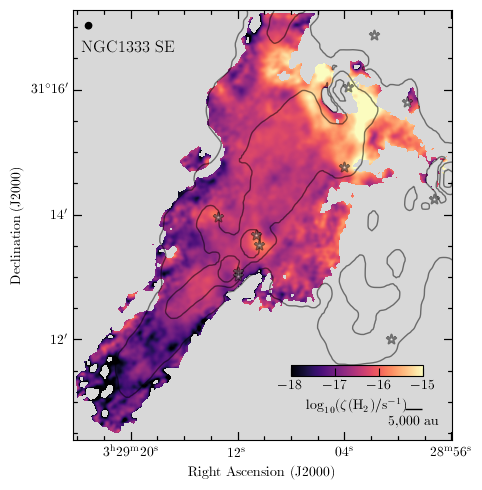

In [28]:
text_color = 'black'

hdu = load_cutout(fits.PrimaryHDU(log_zeta, hd_TdV), is_hdu=True)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='magma').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin=-18, vmax=-15, cmap=cmap, origin='lower')

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_h2=True)

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'$\log_{10}(\zeta({\rm H_2})/{\rm s^{-1}})$', orientation='horizontal')
cbar.set_ticks([-18, -17, -16, -15])

fig.text(xpos_lab1, ypos_lab1, 'NGC1333 SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)

plt.tight_layout()
if save_figures:
    fig.savefig('figs/NGC1333_Zeta.pdf', dpi=200, bbox_inches='tight')

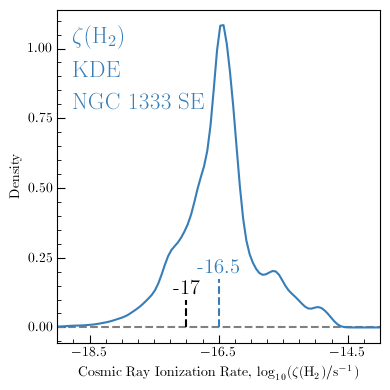

In [29]:
xrange = np.array([-19, -14])

gd_zeta = np.isfinite(log_zeta)
# wt = 1 / NH3_dv[log_xe]**2
#
kde_log_zeta = stats.gaussian_kde(log_zeta[gd_zeta])#, weights=wt)
median_log10_zeta = np.round(np.median(log_zeta[gd_zeta]), decimals=1)

x_sample = np.linspace(xrange[0], xrange[1], num=100)
log_zeta_sample = np.reshape(kde_log_zeta(x_sample).T, x_sample.shape)

fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(xrange, [0, 0], color='gray', linestyle='--')
ax.plot(x_sample, log_zeta_sample, color=color_kde[1])
#
ax.text(0.05, 0.9,  r'$\zeta({\rm H_2})$', color=color_kde[1],
        transform=ax.transAxes, size=17, weight=60)
ax.text(0.05, 0.8,  r'KDE', color=color_kde[1],
        transform=ax.transAxes, size=17, weight=60)
ax.text(0.05, 0.7,  r'NGC 1333 SE', color=color_kde[1],
        transform=ax.transAxes, size=17, weight=60)

ax.set_xlabel(r"Cosmic Ray Ionization Rate, $\log_{10}(\zeta({\rm H_2}) / {\rm s^{-1}})$")
ax.set_ylabel(r"Density")
ax.set_xlim(xrange)

zeta_list = [np.round(np.log10(zeta_standard), decimals=0).astype(int), 
#              np.round(np.log10(zeta_vanderTak2000), decimals=1), 
             median_log10_zeta]
zeta_dy_list = [0.0, 0.075]#, 0.0]
zeta_color_list = ['k', color_kde[1]]#, color_kde[1]]

for (zeta_i, dy_i, zeta_i_color) in zip(zeta_list, zeta_dy_list, zeta_color_list):
    ax.plot([zeta_i, zeta_i], [0, 0.1 + dy_i], color=zeta_i_color, linestyle='--')
    ax.text(zeta_i, 0.115 + dy_i, zeta_i, color=zeta_i_color, 
            horizontalalignment='center', size=15, weight=60)
    
ax.xaxis.set_minor_locator(MultipleLocator(0.25))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))

ax.set_xticks([-18.5, -16.5, -14.5])
ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])

plt.tight_layout()
if save_figures:
    fig.savefig('figs/NGC1333_log_zeta_KDE.pdf', dpi=100, bbox_inches='tight')

In [30]:
log_zeta_min = -19
log_zeta_max = -14

log_H2_min = 21.5
log_H2_max = 24.0

mask_local_cr = fits.getdata('data/NGC1333_SE_mask.fits')

gd_map = np.isfinite( 1./ (hdu_log10_h2.data * log_zeta)) * (mask_local_cr == 0)
my_X = hdu_log10_h2.data[gd_map]
my_Y = log_zeta[gd_map]

xx_log_H2_zeta, yy_log_H2_zeta = np.mgrid[log_H2_min:log_H2_max:100j, log_zeta_min:log_zeta_max:100j]
positions = np.vstack([xx_log_H2_zeta.ravel(), yy_log_H2_zeta.ravel()])
values = np.vstack([my_X, my_Y])

kernel_log_H2_zeta = stats.gaussian_kde(values)
my_Z = np.reshape(kernel_log_H2_zeta(positions).T, xx_log_H2_zeta.shape)

In [31]:
poly_model_h = np.array([1.001098610761e7, -4.231294690194e6, 
                         7.921914432011e5, -8.623677095423e4, 
                         6.015889127529e3, -2.789238383353e2, 
                         8.595814402406, -1.698029737474e-1, 
                         1.951179287567e-3, -9.937499546711e-6])
poly_model_l = np.array([-3.331056497233e6, 1.207744586503e6, 
                         -1.913914106234e5, 1.731822350618e4, 
                         -9.790557206178e2, 3.543830893824e1,
                         -8.034869454520e-1, 1.048808593086e-2,
                         -6.188760100997e-5, 3.122820990797e-8])

log_N_H2_sample = np.arange(21.5, 23.9, 0.1)
log_zeta_sample_h = polyval(log_N_H2_sample, poly_model_h)
log_zeta_sample_l = polyval(log_N_H2_sample, poly_model_l)

### Overplot Polarisation Vectors
We add the vectors from the BISTRO NGC1333 data. Here is better to also show the outflow directions. We add the list of YSO coordinates and outflow positions from the literature.

In [32]:
#
ra_iras2b = 15*(3 + (28 + 57.37/60.)/60.) * u.deg
dec_iras2b = (31 + (14 + 15.77/60.)/60.) * u.deg
PA_iras2b = 24.0
#
ra_iras4a = 15*(3 + (29 + 10.5/60.)/60.) * u.deg
dec_iras4a = (31 + (13 + 31.5/60.)/60.) * u.deg
PA_iras4a = 8.0
#
ra_iras4b = 15*(3 + (29 + 12.0/60.)/60.) * u.deg
dec_iras4b = (31 + (13 + 08.1/60.)/60.) * u.deg
PA_iras4b = 0.0
# 
ra_iras4c = 15*(3 + (29 + 13.55/60.)/60.) * u.deg
dec_iras4c = (31 + (13 + 58.11/60.)/60.) * u.deg
PA_iras4c = 96.0
#
ra_svs13a = 15*(3 + (29 + 3.7/60.)/60.) * u.deg 
dec_svs13a = (31 + (16 + 3.1/60.)/60.) * u.deg
PA_svs13a = -50.0
#
ra_svs13b = 15*(3 + (29 + 3.1/60.)/60.) * u.deg
dec_svs13b = (31 + (15 + 51.5/60.)/60.) * u.deg
PA_svs13b = 170.0
#
ra_svs13c = 15*(3 + (29 + 1.9/60.)/60.) * u.deg
dec_svs13c = (31 + (15 + 38.6/60.)/60.) * u.deg
PA_svs13c = 8.0
#
ra_per_emb_15 = 15*(3 + (29 + 4.1/60.)/60.) * u.deg
dec_per_emb_15 = (31 + (14 + 46.2/60.)/60.) * u.deg
PA_per_emb_15 = -35.0
#
ra_per_emb_3 = 15*(3 + (29 + 0.58/60.)/60.) * u.deg
dec_per_emb_3 = (31 + (12 + 0.2/60.)/60.) * u.deg
PA_per_emb_3 = 97.0


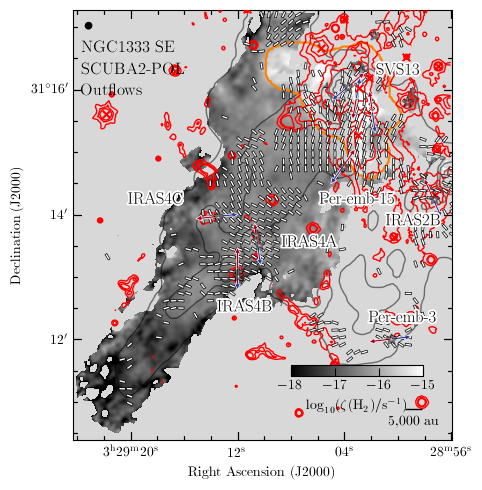

In [33]:
text_color = 'black'

hdu = load_cutout(fits.PrimaryHDU(log_zeta, hd_TdV), is_hdu=True)
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='gray').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin=-18, vmax=-15, cmap=cmap, origin='lower')

plot_setup_noema_wcsaxes(ax, hdu, label_col=text_color, contour_h2=True)

cax = ax.inset_axes(col_pos, zorder=25)
cbar = plt.colorbar(im, cax=cax, label=r'$\log_{10}(\zeta({\rm H_2})/{\rm s^{-1}})$', 
                    orientation='horizontal')

# add polarisation vectors from BISTRO
for ra_i, dec_i, dra_i, ddec_i in zip(ra_pol, dec_pol, dra_pol, ddec_pol):
    position_i = SkyCoord(ra_i * u.deg, dec_i * u.deg, frame='fk5')
    # two pieces of coordinates
    position_vector_1 = position_i.spherical_offsets_by(dra_i * u.arcsec, ddec_i * u.arcsec)
    position_vector_2 = position_i.spherical_offsets_by(-dra_i * u.arcsec, -ddec_i * u.arcsec)
    ax.plot([position_vector_1.ra.deg, position_vector_2.ra.deg], 
            [position_vector_1.dec.deg, position_vector_2.dec.deg], zorder=10, 
            color='black', transform=ax.get_transform('world'), lw=2)
    ax.plot([position_vector_1.ra.deg, position_vector_2.ra.deg], 
            [position_vector_1.dec.deg, position_vector_2.dec.deg], zorder=11,
            color='white', transform=ax.get_transform('world'), lw=1)

# Region Label
fig.text(xpos_lab1, ypos_lab1, 'NGC1333 SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
# txt = 
fig.text(xpos_lab2, ypos_lab2, 'SCUBA2-POL', transform=ax.transAxes, zorder=22,
                horizontalalignment='left', color=text_color, size=12)

fig.text(xpos_lab3, ypos_lab3, ' Outflows', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)

# Add YSO outflows
pos_iras2b = SkyCoord(ra_iras2b, dec_iras2b, frame='fk5')
pos_iras4a = SkyCoord(ra_iras4a, dec_iras4a, frame='fk5')
pos_iras4b = SkyCoord(ra_iras4b, dec_iras4b, frame='fk5')
pos_iras4c = SkyCoord(ra_iras4c, dec_iras4c, frame='fk5')
pos_svs13a = SkyCoord(ra_svs13a, dec_svs13a, frame='fk5')
pos_svs13b = SkyCoord(ra_svs13b, dec_svs13b, frame='fk5')
pos_svs13c = SkyCoord(ra_svs13c, dec_svs13c, frame='fk5')
pos_per_emb_15 = SkyCoord(ra_per_emb_15, dec_per_emb_15, frame='fk5')
pos_per_emb_3 = SkyCoord(ra_per_emb_3, dec_per_emb_3, frame='fk5')
pos_yso_list = [pos_iras4a, pos_iras4b, pos_iras4c, 
                pos_svs13a, pos_svs13b, pos_svs13c, 
                pos_per_emb_15, pos_per_emb_3,
                pos_iras2b]
PA_yso_list = [PA_iras4a, PA_iras4b, PA_iras4c, 
               PA_svs13a, PA_svs13b, PA_svs13c, 
               PA_per_emb_15, PA_per_emb_3,
               PA_iras2b]
#
for pos_yso_i, PA_i in zip(pos_yso_list, PA_yso_list):
    angles_yso_i = np.array([PA_i, PA_i + 180])*u.deg
    ax.quiver([pos_yso_i.ra.deg, pos_yso_i.ra.deg], 
              [pos_yso_i.dec.deg, pos_yso_i.dec.deg], 
              -3*np.sin(angles_yso_i).value,
              3*np.cos(angles_yso_i).value,
              angles='uv', color=['#a50026', '#313695'], 
              zorder=15, width=0.005, 
              headwidth=3, headlength=3, headaxislength=3,
              transform=ax.get_transform('world'), lw=0.5, edgecolors='w')

color_YSO = '#ec7014'
color_YSO = '#ffff33'
color_YSO = 'k'
# SVS 13
txt = fig.text(0.8, 0.85, 'SVS13', transform=ax.transAxes, weight='semibold',
                horizontalalignment='left', color='k', size=12)
txt.set_path_effects([PathEffects.withStroke(linewidth=2.5, foreground='w')])
# Per-emb-15
txt = fig.text(0.65, 0.55, 'Per-emb-15', transform=ax.transAxes, weight='semibold',
                horizontalalignment='left', color='k', size=12)
txt.set_path_effects([PathEffects.withStroke(linewidth=2.5, foreground='w')])
# IRAS 2B
txt = fig.text(0.825, 0.5, 'IRAS2B', transform=ax.transAxes, weight='semibold',
                horizontalalignment='left', color=color_YSO, size=12)
txt.set_path_effects([PathEffects.withStroke(linewidth=2.5, foreground='w')])
# Per-emb-3
txt = fig.text(0.78, 0.275, 'Per-emb-3', transform=ax.transAxes, weight='semibold',
                horizontalalignment='left', color='k', size=12)
txt.set_path_effects([PathEffects.withStroke(linewidth=2.5, foreground='w')])
# IRAS 4A
txt = fig.text(0.55, 0.45, 'IRAS4A', transform=ax.transAxes, weight='semibold',
                horizontalalignment='left', color=color_YSO, size=12)
txt.set_path_effects([PathEffects.withStroke(linewidth=2.5, foreground='w')])
# IRAS 4B
txt = fig.text(0.38, 0.3, 'IRAS4B', transform=ax.transAxes, weight='semibold',
                horizontalalignment='left', color=color_YSO, size=12)
txt.set_path_effects([PathEffects.withStroke(linewidth=2.5, foreground='w')])
# IRAS 4C
txt = fig.text(0.3, 0.55, 'IRAS4C', transform=ax.transAxes, weight='bold',
                horizontalalignment='right', color=color_YSO, size=12)
txt.set_path_effects([PathEffects.withStroke(linewidth=2.5, foreground='w')])

# Add X-Ray sources
ax.scatter(ra_xray, dec_xray, marker='x', s=30, zorder=20,
           transform=ax.get_transform('world'), color='r')
# Add active region selection
ax.contour(mask_local_cr, levels=[0.5], colors='#ff7f00')

plt.tight_layout()
if save_figures:
    fig.savefig('figs/NGC1333_Zeta_gray.pdf', dpi=200, bbox_inches='tight')

hdu_Spitzer = load_cutout('data/NGC1333_IRAC2.fits', is_hdu=False)
ax.contour(hdu_Spitzer.data, levels=[0.7, 1.4, 2.8],
           transform=ax.get_transform(WCS(hdu_Spitzer.header)), 
           colors='red', linewidths=1, alpha=1)

if save_figures:
    fig.savefig('figs/NGC1333_Zeta_gray_Spitzer.pdf', dpi=200, bbox_inches='tight')

### Comparison of MHD wave cut-off
We use the relation,
\begin{equation}
\lambda_{min} = \sqrt{\frac{\pi}{4 \mu\, m_{\rm H} n({\rm H_2})}} \frac{B_o}{n({\rm H_2})\, X(e)\, \langle \sigma\, v \rangle}~, 
\end{equation}
where $B_o$ is the unperturbed magnetic field and 
$\langle \sigma\, v \rangle$ is the is the rate coefficient for elastic collisions.

We estimate the magnetic field using the volume density relation proposed by Crutcher et al (2010).

In [34]:
mean_n_H2 = 10**(mean_log_n_H2) / u.cm**3
mean_X_e = 10**(median_log10_xe)
# B_o = 300 * u.uG # BISTRO paper
sig_v = 1.69e-9*u.cm**3/u.s

gauss_B = (u.g/u.cm)**(0.5)/u.s
equiv_B = [(u.G, gauss_B, lambda x: x, lambda x: x)]

def Bfield_Crutcher(density):
    """
    Magnetic field strength as a function of volume density 
    """
    B_init = 10 * u.uG
    density_init = 300 / u.cm**3
    alpha_init = 0.65
    if (density < density_init):
        return B_init
    else:
        return B_init * np.power(density / density_init, alpha_init)

In [35]:
lamda_MHD = (np.sqrt(np.pi/(4 * 2.8 * u.u * mean_n_H2).cgs) * Bfield_Crutcher(mean_n_H2).to((u.g/u.cm)**(1/2)/u.s, equivalencies=equiv_B) / (mean_n_H2 * mean_X_e * sig_v)).to(u.pc)
print(np.round(lamda_MHD, decimals=3))

0.054 pc


In [36]:
print(np.round(lamda_MHD.to(u.au), decimals=-2))

11100.0 AU


In [37]:
print(np.round(lamda_MHD.to(u.au).value/ distance, decimals=0)) 

37.0


### Calculate radial profile around some YSOs
For each pixel, we calculate the projected distance to the embedded protostars shown in the figure of the polarisation vector. We plot the KDE of the CRIR vs the distance calculated as:
$$
\frac{1}{d_{YSO}^2} = \frac{1}{N} \sum_{i=0}^N \frac{1}{d_i^2}~.
$$

In [38]:
def zeta_distance_yso(hd, ra_ctr, dec_ctr, distance=300.*u.pc):
    results = c_offset.generate_offsets(hd, ra_ctr, dec_ctr, 
                                        pa_angle=0*u.deg, inclination=0*u.deg)
    rad_au = (results.r * distance).to(u.au, equivalencies=u.dimensionless_angles())
    return rad_au

In [39]:
rad_iras4a = zeta_distance_yso(hd_TdV, ra_iras4a, dec_iras4a)

In [40]:
rad_iras4b = zeta_distance_yso(hd_TdV, ra_iras4b, dec_iras4b)

In [41]:
rad_iras4c = zeta_distance_yso(hd_TdV, ra_iras4c, dec_iras4c)

In [42]:
rad_svs13a = zeta_distance_yso(hd_TdV, ra_svs13a, dec_svs13a)

In [43]:
rad_svs13b = zeta_distance_yso(hd_TdV, ra_svs13b, dec_svs13b)

In [44]:
rad_svs13c = zeta_distance_yso(hd_TdV, ra_svs13c, dec_svs13c)

In [45]:
rad_per_emb_15 = zeta_distance_yso(hd_TdV, ra_per_emb_15, dec_per_emb_15)

In [46]:
rad_mean = np.sqrt(1. /
                      np.mean(np.stack([1. / rad_iras4a**2,
                        1. / rad_iras4b**2,
                        1. / rad_iras4c**2,
                        1. / rad_svs13a**2,
                        1. / rad_svs13b**2,
                        1. / rad_svs13c**2,
                        1. / rad_per_emb_15**2], axis=0), 
                              axis=0))

log_rad_mean = np.log10(rad_mean.to(u.au).value)

log_zeta_min = -19
log_zeta_max = -14

log_r_mean_min = 3.
log_r_mean_max = 6.5
#

gd_rad_map = np.isfinite( 1./ (log_zeta * log_rad_mean)) * (mask_local_cr == 0) 

my_X = log_rad_mean[gd_rad_map]
my_Y = log_zeta[gd_rad_map]

xx_log_rad_zeta, yy_log_rad_zeta = np.mgrid[log_r_mean_min:log_r_mean_max:150j, 
                                            log_zeta_min:log_zeta_max:150j]
positions = np.vstack([xx_log_rad_zeta.ravel(), yy_log_rad_zeta.ravel()])
values = np.vstack([my_X, my_Y])

kernel_log_rad_zeta = stats.gaussian_kde(values)
my_Z_rad_zeta = np.reshape(kernel_log_rad_zeta(positions).T, 
                           xx_log_rad_zeta.shape)

In [47]:
radius_sample = 10**np.arange(3.0, 4.9, 0.1)

def profile_zeta(radius, zeta_amp=6e-17, zeta_break=1.3e4, zeta_alpha=-2):
    zeta_radius = np.piecewise(radius, 
                    [radius < zeta_break, radius >= zeta_break], 
                    [zeta_amp, lambda radius: zeta_amp * (radius / zeta_break)**zeta_alpha])
    return zeta_radius

In [48]:
median_log10_xe

-6.5

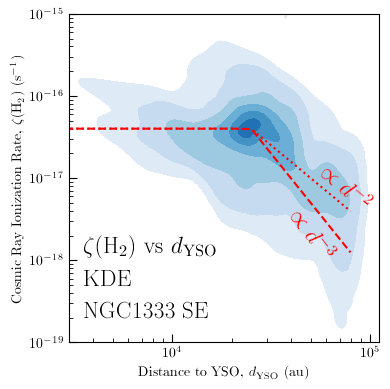

In [49]:
fig, ax = plt.subplots(figsize=(4, 4))

cfset = ax.contourf(10**xx_log_rad_zeta, 10**yy_log_rad_zeta, 
                    my_Z_rad_zeta, colors=color_levels2, 
                    levels=levels_norm_l * my_Z_rad_zeta.max())

ax.set_xlabel(r"Distance to YSO, $d_{\rm YSO}$ (au)")
ax.set_ylabel(r"Cosmic Ray Ionization Rate, $\zeta({\rm H_2})$ (${\rm s^{-1}}$)")

ax.text(0.05, 0.075,  r'NGC1333 SE', color='black', 
        transform=ax.transAxes, size=17, weight=60)
ax.text(0.05, 0.175,  r'KDE', color='black', 
        transform=ax.transAxes, size=17, weight=60)
ax.text(0.05, 0.275,  r'$\zeta({\rm H_2})$ vs $d_{\rm YSO}$', color='black', 
        transform=ax.transAxes, size=17, weight=60)

ax.plot(radius_sample, profile_zeta(radius_sample, zeta_amp=4e-17, zeta_break=2.5e4, zeta_alpha=-3),
        color='red', ls='--')
ax.plot(radius_sample, profile_zeta(radius_sample, zeta_amp=4e-17, zeta_break=2.5e4, zeta_alpha=-2),
        color='red', ls=':')
ax.text(0.8, 0.4,  r'$\propto d^{-2}$', color='red', 
        transform=ax.transAxes, size=17, weight=60, rotation=-40)
ax.text(0.7, 0.25,  r'$\propto d^{-3}$', color='red', 
        transform=ax.transAxes, size=17, weight=60, rotation=-52)

plt.loglog()
ax.set_xlim([3e3, 1.1e5])
ax.set_ylim([10**(-19), 10**(-15)])
#
#
plt.tight_layout()
if save_figures:
    fig.savefig('figs/NGC1333_log_zeta_log_d_YSO_KDE.pdf', dpi=100, bbox_inches='tight')

## Comparison between YSO luminosity and CRIR

The referee asked if there was a relation between the YSO bolometric luminosity and the CRIR measured in the map. Here we list the bolometric luminosities, $L_{bol}$, for the YSOs in the map. We use these values to compare with the CRIR. This figure does not go into the paper, since it is not very informative.

IRAS 2B    5.30  (Tobin2016)   5.3  Enoch(2009)

IRAS 4A    7.00  (Tobin2016)   4.2  Enoch(2009)

IRAS 4B    4.40  (Tobin2016)   1.6  Enoch(2009)

IRAS 4C    0.70  (Tobin2016)   0.49 Enoch(2009)

SVS 13A    32.5  (Tobin2016)   32.5 Enoch(2009)

SVS 13B    1.00  (Tobin2016)   1-2 --  

SVS 13C    1.50  (Tobin2016)   --  

Per-emb-3  0.5   (Tobin2016)   0.69 Enoch(2009)

Per-emb-15 0.40  (Tobin2016)   0.53 Enoch(2009)

In [50]:
CRIR_iras4a = log_zeta[np.unravel_index(np.argmin(rad_iras4a, axis=None), rad_svs13a.shape)]
CRIR_iras4b = log_zeta[np.unravel_index(np.argmin(rad_iras4b, axis=None), rad_svs13a.shape)]
CRIR_iras4c = log_zeta[np.unravel_index(np.argmin(rad_iras4c, axis=None), rad_svs13a.shape)]
CRIR_svs13a = log_zeta[np.unravel_index(np.argmin(rad_svs13a, axis=None), rad_svs13a.shape)]
CRIR_svs13b = log_zeta[np.unravel_index(np.argmin(rad_svs13b, axis=None), rad_svs13a.shape)]
CRIR_svs13c = log_zeta[np.unravel_index(np.argmin(rad_svs13c, axis=None), rad_svs13a.shape)]
CRIR_per_emb_15 = log_zeta[np.unravel_index(np.argmin(rad_per_emb_15, axis=None), rad_svs13a.shape)]

CRIR_list = np.array([CRIR_iras4a, CRIR_iras4b, CRIR_iras4c,
                      CRIR_svs13a, CRIR_svs13b, CRIR_svs13c, 
                      CRIR_per_emb_15])

Lbol_iras4a = 7.0
Lbol_iras4b = 4.4
Lbol_iras4c = 0.7
Lbol_svs13a = 32.5
Lbol_svs13b = 1.0
Lbol_svs13c = 1.5
Lbol_per_emb_15 = 0.4
Lbol_list = np.array([Lbol_iras4a, Lbol_iras4b, Lbol_iras4c,
                      Lbol_svs13a, Lbol_svs13b, Lbol_svs13c, 
                      Lbol_per_emb_15])

Text(0, 0.5, 'Cosmic Ray Ionization Rate, $\\log_{10} \\zeta({\\rm H_2}) {\\rm s}$')

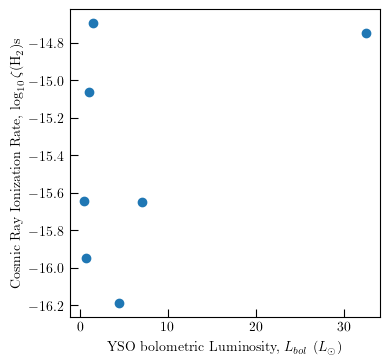

In [51]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(Lbol_list, CRIR_list)
ax.set_xlabel(r"YSO bolometric Luminosity, $L_{bol}$ ($L_\odot$)")
ax.set_ylabel(r"Cosmic Ray Ionization Rate, $\log_{10} \zeta({\rm H_2}) {\rm s}$")

We estimate the error in the column density estimates if we use the wrong excitation temperature.
We also estimate the typical error in deriving $X(e)$ and $\zeta({\rm H_2})$ for the typical values of $R_H$ and $R_D$ derived in the map, and for two typical values of the depletion factor, $f_D=8, 10$.

In [52]:
Tex_sample = np.linspace(5, 30, 20)

RD_0 = 0.1#
RH_0 = np.nanmedian(R_H)

N_C18O_12K = Ncol_C18O(1*u.K*u.km/u.s, Tex=12*u.K) 

H13COp_Ncol_sample = col_h13cop.H13COp_thin(J_up=1, Tex=Tex_sample*u.K, TdV=1*u.K*u.km/u.s)
H13COp_Ncol_sample_0 = col_h13cop.H13COp_thin(J_up=1, Tex=T_ex_DCOp, TdV=1*u.K*u.km/u.s)
DCOp_Ncol_sample = col_dcop.DCOp_thin(J_up=1, Tex=Tex_sample*u.K, TdV=1*u.K*u.km/u.s)
DCOp_Ncol_sample_0 = col_dcop.DCOp_thin(J_up=1, Tex=T_ex_DCOp, TdV=1*u.K*u.km/u.s)

RD_sample = RD_0 * (DCOp_Ncol_sample / DCOp_Ncol_sample_0) / (H13COp_Ncol_sample / H13COp_Ncol_sample_0)
RH_sample = RH_0 * (H13COp_Ncol_sample / H13COp_Ncol_sample_0)

f_D_8 = 8.0
f_D_10 = 10.0
#
xe_fd_8 = 2.7e-8 / RD_0 - 1.2e-6 / f_D_8
xe_fd_10 = 2.7e-8 / RD_0 - 1.2e-6 / f_D_10
#
xe_fd_sample_8 = (2.7e-8 / RD_sample - 1.2e-6 / f_D_8) #/ xe_fd_8
xe_fd_sample_10 = (2.7e-8 / RD_sample - 1.2e-6 / f_D_10) #/ xe_fd_10
#
zeta_fd_8 = (7.5e-4 * xe_fd_8 + 4.6e-10/f_D_8) * xe_fd_8 * RH_0
zeta_fd_10 = (7.5e-4 * xe_fd_10 + 4.6e-10/f_D_10) * xe_fd_10 * RH_0
#
zeta_fd_sample_8 = (7.5e-4 * xe_fd_sample_8 + 4.6e-10/f_D_8) * xe_fd_sample_8 * RH_sample
zeta_fd_sample_10 = (7.5e-4 * xe_fd_sample_10 + 4.6e-10/f_D_10) * xe_fd_sample_10 * RH_sample

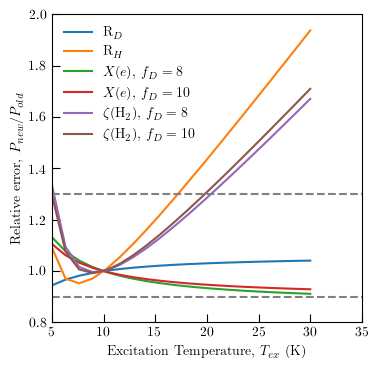

In [53]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.plot(Tex_sample, RD_sample / RD_0, label=r'R$_D$')
ax.plot(Tex_sample, RH_sample / RH_0, label=r'R$_H$')
#
ax.plot(Tex_sample, xe_fd_sample_8 / xe_fd_8, label=r'$X(e)$, $f_D=8$')
ax.plot(Tex_sample, xe_fd_sample_10 / xe_fd_10, label=r'$X(e)$, $f_D=10$')

#
ax.plot(Tex_sample, zeta_fd_sample_8 / zeta_fd_8, label=r'$\zeta({\rm H_2})$, $f_D=8$')
ax.plot(Tex_sample, zeta_fd_sample_10 / zeta_fd_10, label=r'$\zeta({\rm H_2})$, $f_D=10$')

ax.set_xlim([5, 35])
ax.set_ylim([0.8, 2])

ax.set_xlabel(r"Excitation Temperature, $T_{ex}$ (K)")
ax.set_ylabel(r"Relative error, $P_{new}/P_{old}$")
ax.hlines(0.9, 5, 35, linestyle='--', color='gray')
ax.hlines(1.3, 5, 35, linestyle='--', color='gray')
plt.legend(frameon=False, loc=2)